# Necessary imports and data loading

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
import numpy as np
import sklearn
import sklearn.ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
import tqdm
import joblib

In [2]:
data = pd.read_csv('../data/combined.csv').drop(columns='Unnamed: 0')

## EDA

In [3]:
data.head()

,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,SlottedA_length,StetsonK_AC,Con,Beyond1Std,SmallKurtosis,...,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,Gskew,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
0,0.0325,0.152123,0.776471,0.001148,3,4.56594,0.742826,0.012048,0.310000,0.496495,...,-0.993324,0.0,-2.322174,-1.541233,0.318823,-0.016,1.553560,1.876786,1.313997,lpv
1,0.1930,0.310889,0.774050,0.006507,18,0.32270,0.785196,0.034137,0.328000,-0.013290,...,-1.742568,0.0,-0.310323,0.589431,-1.346502,0.032,1.707247,2.269266,1.367730,lpv
2,0.0145,0.144332,0.787095,0.000516,2,0.00631,0.708395,0.002717,0.321622,0.278947,...,-1.199446,0.0,-1.609793,-0.594308,-0.107063,0.007,2.014262,3.044352,1.583893,lpv
3,0.0600,0.237003,0.827779,0.002417,8,3.63596,0.695801,0.008032,0.360000,-0.563115,...,1.409946,0.0,0.299966,1.309834,2.109992,0.022,1.722238,2.330480,1.435160,lpv
4,0.1955,0.289074,0.774210,0.006886,21,45.91152,0.889680,0.038153,0.344000,-0.275392,...,-0.859084,0.0,-0.063912,-2.265651,-0.148202,0.112,1.711038,2.317218,1.393307,lpv


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443381 entries, 0 to 443380
Data columns (total 64 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Amplitude                        443381 non-null  float64
 1   Rcs                              443381 non-null  float64
 2   StetsonK                         443381 non-null  float64
 3   Meanvariance                     443381 non-null  float64
 4   Autocor_length                   443381 non-null  int64  
 5   SlottedA_length                  443381 non-null  float64
 6   StetsonK_AC                      443381 non-null  float64
 7   Con                              443381 non-null  float64
 8   Beyond1Std                       443381 non-null  float64
 9   SmallKurtosis                    443381 non-null  float64
 10  Std                              443381 non-null  float64
 11  Skew                             443381 non-null  float64
 12  Ma

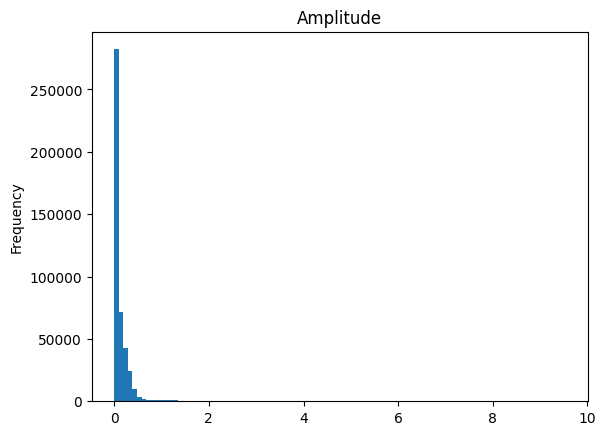

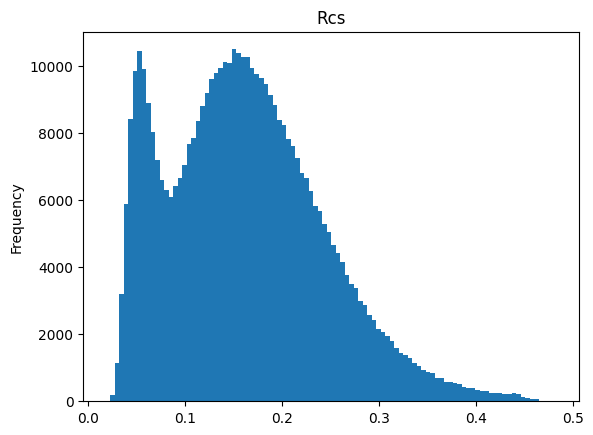

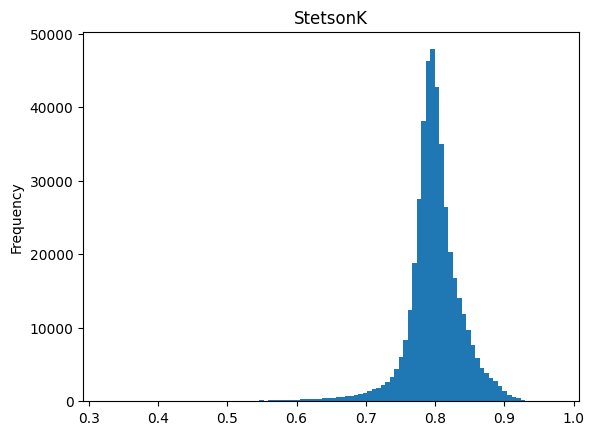

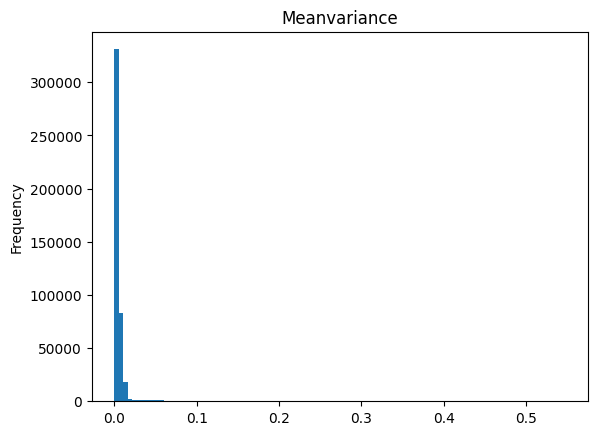

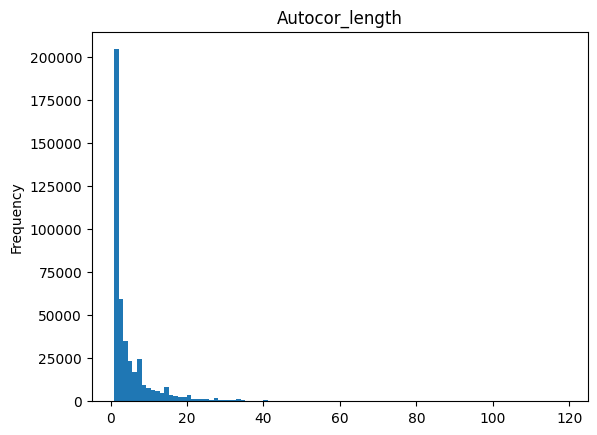

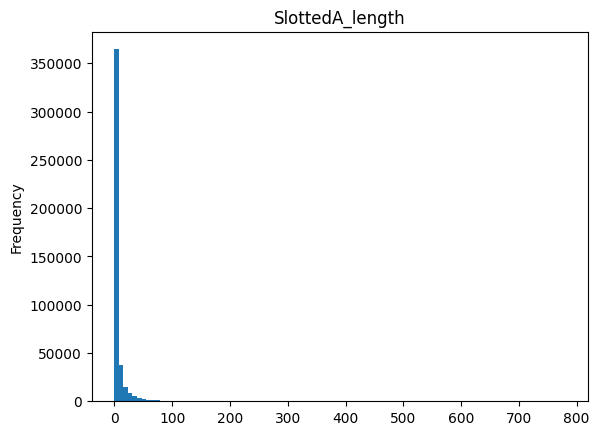

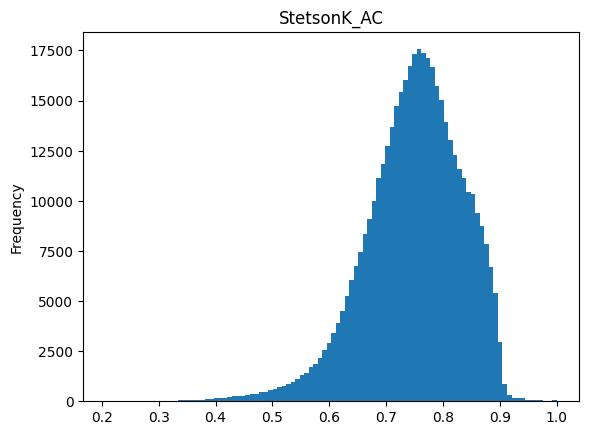

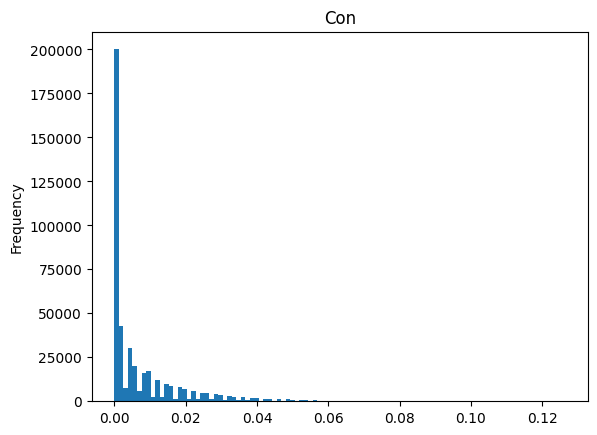

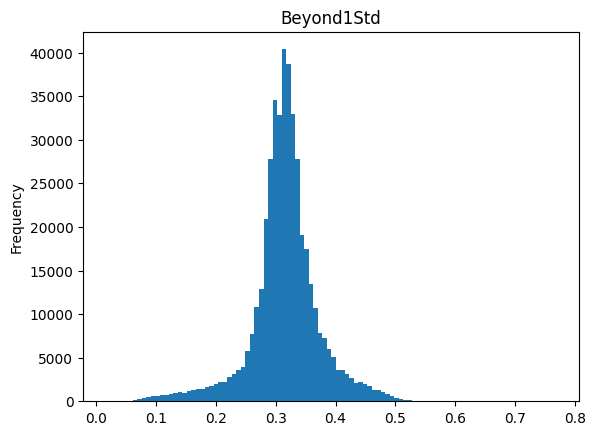

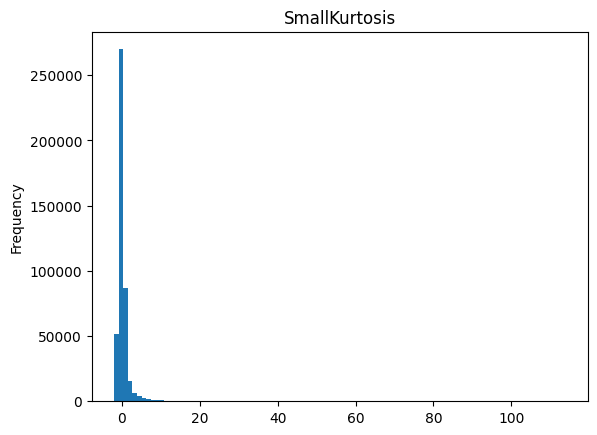

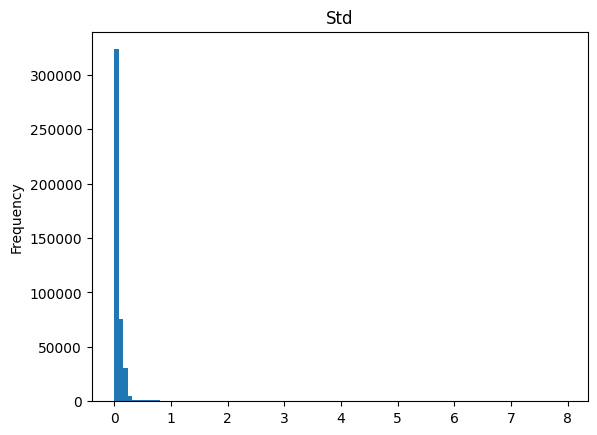

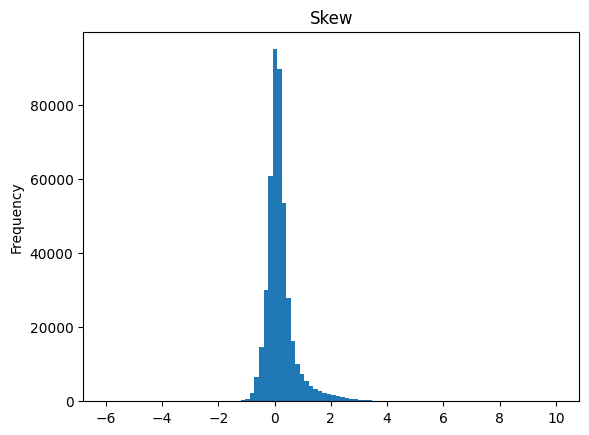

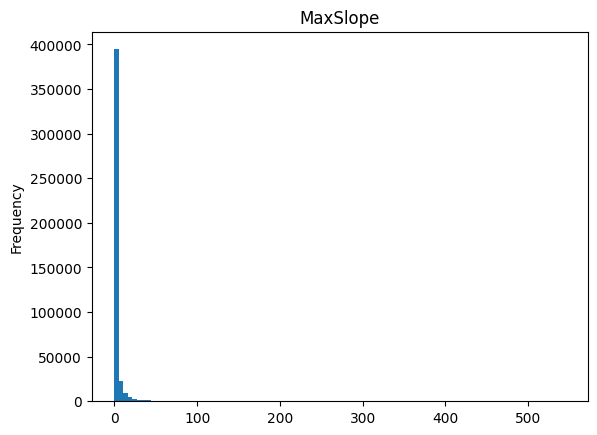

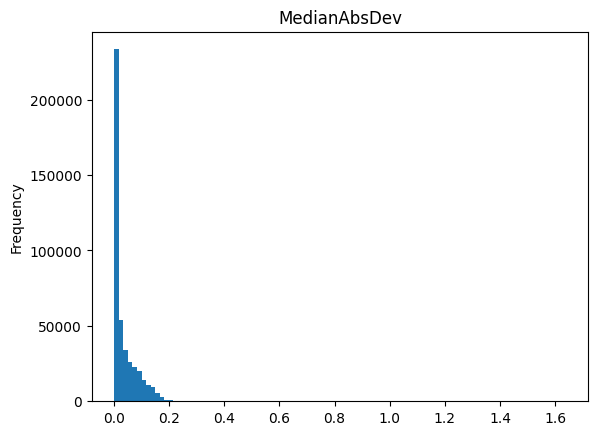

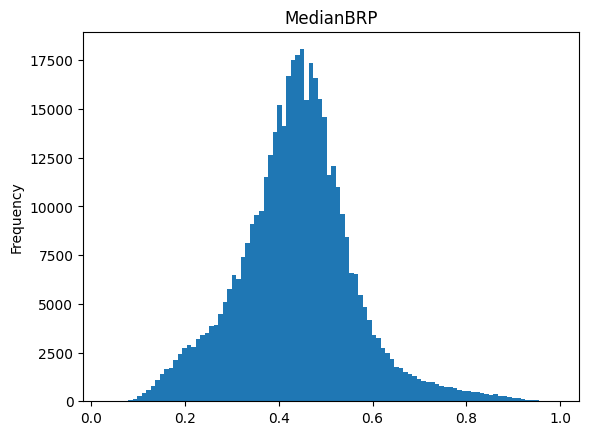

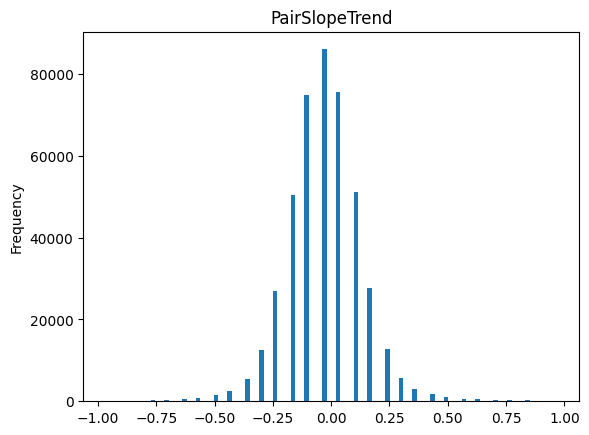

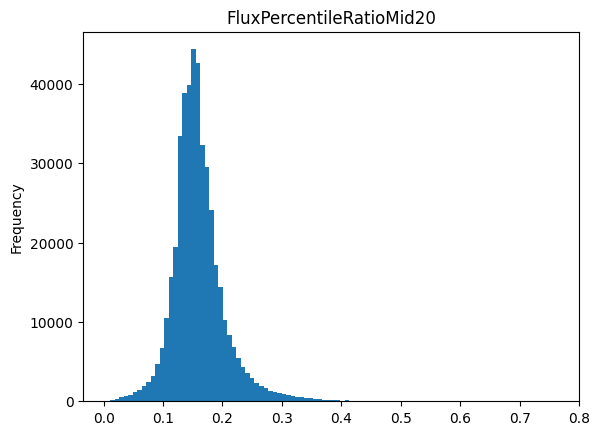

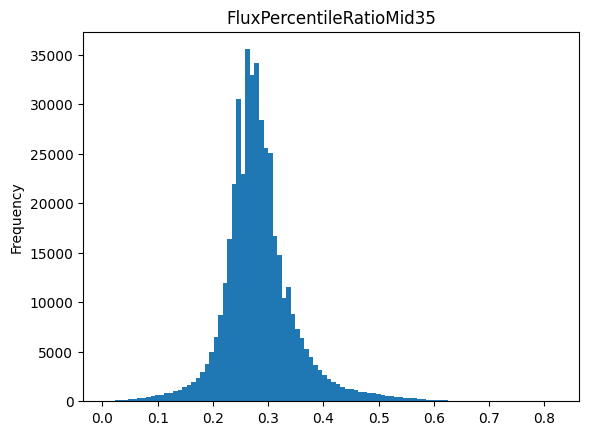

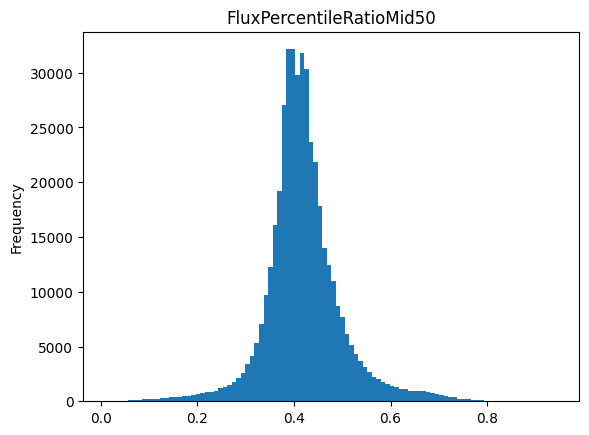

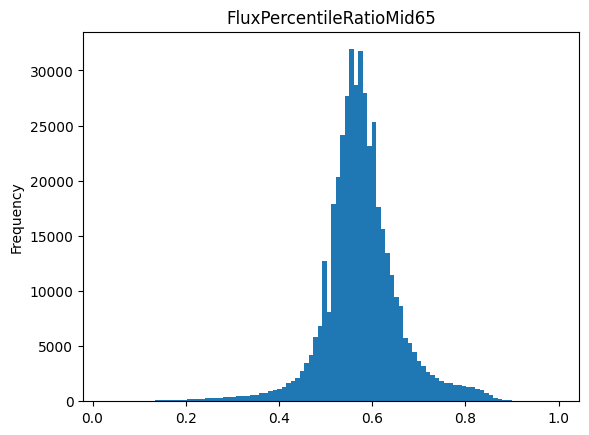

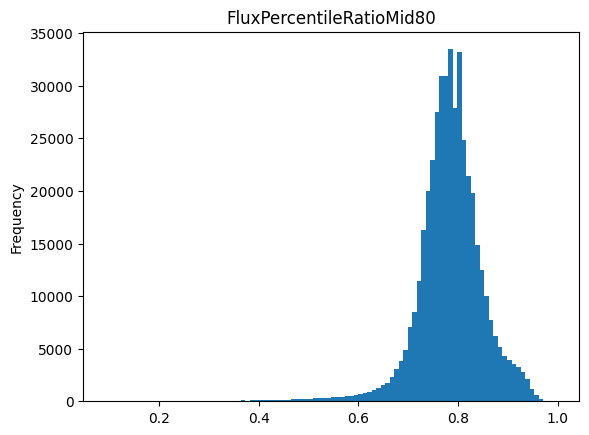

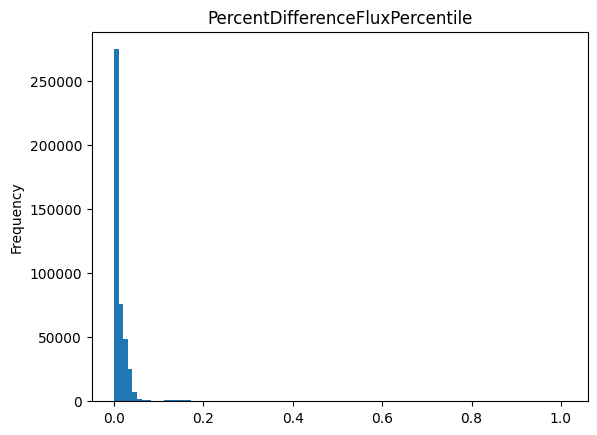

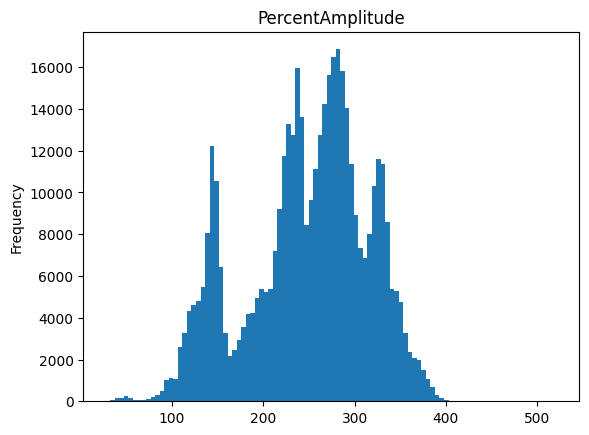

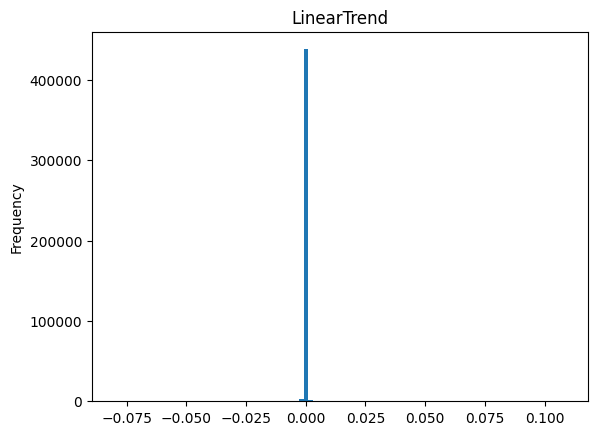

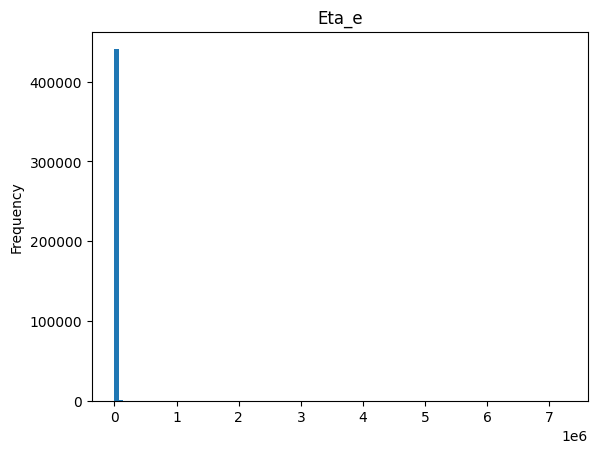

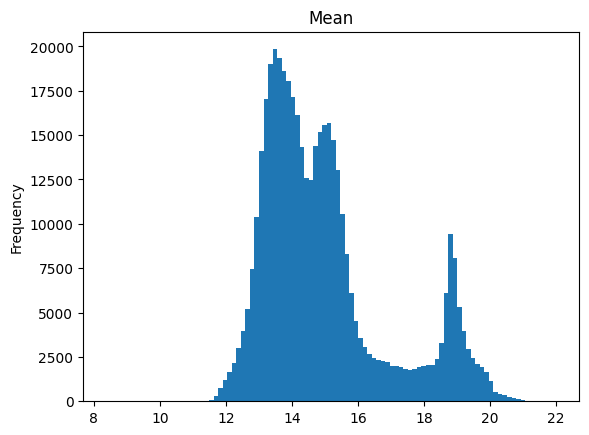

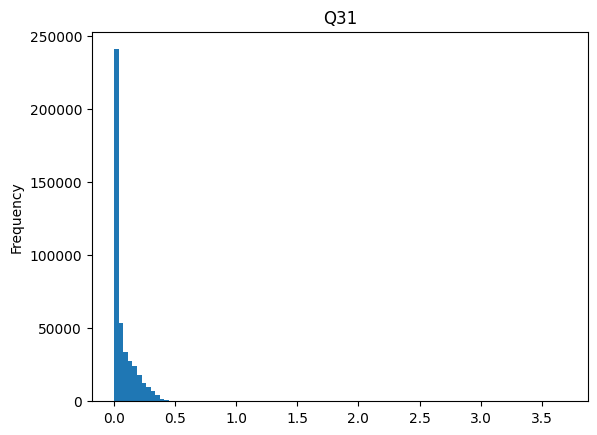

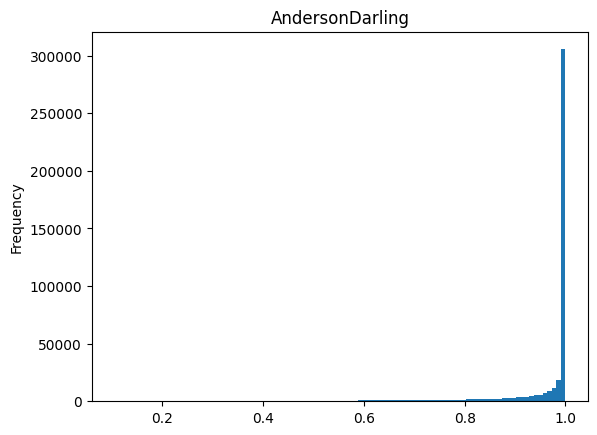

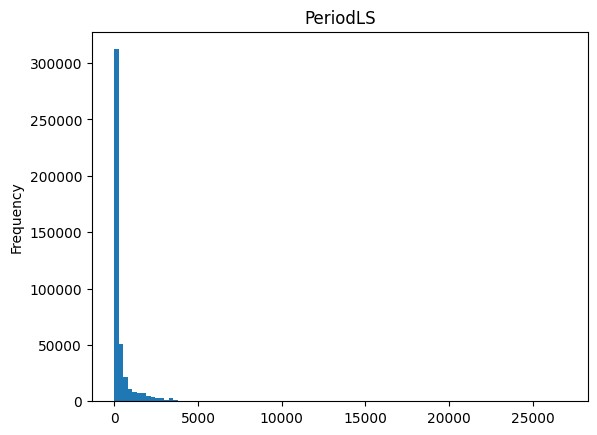

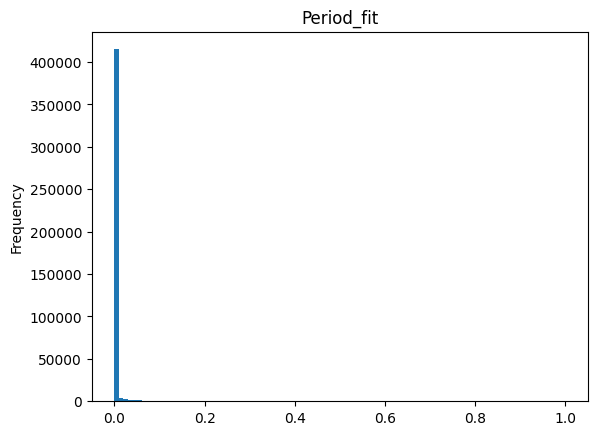

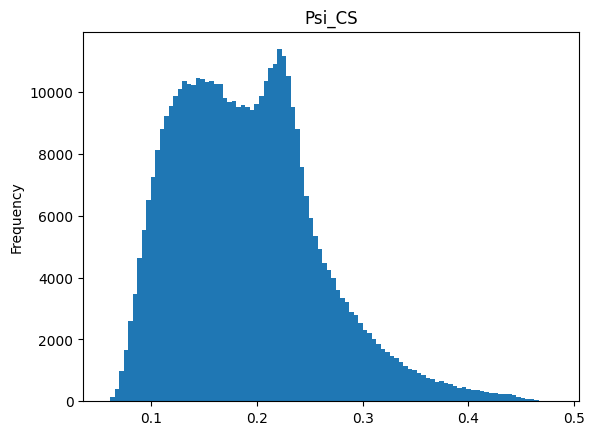

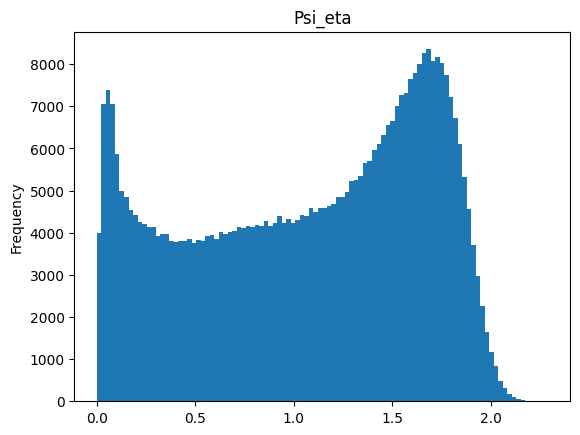

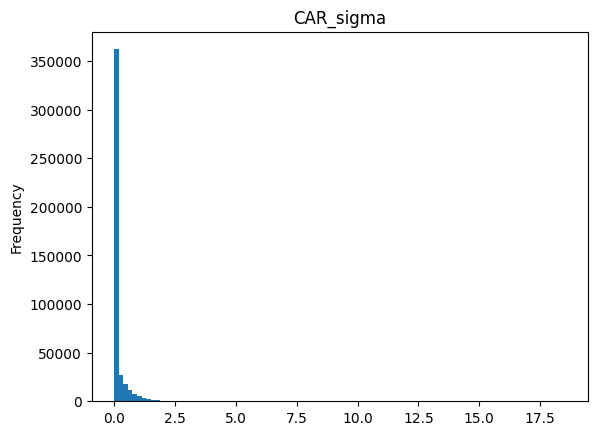

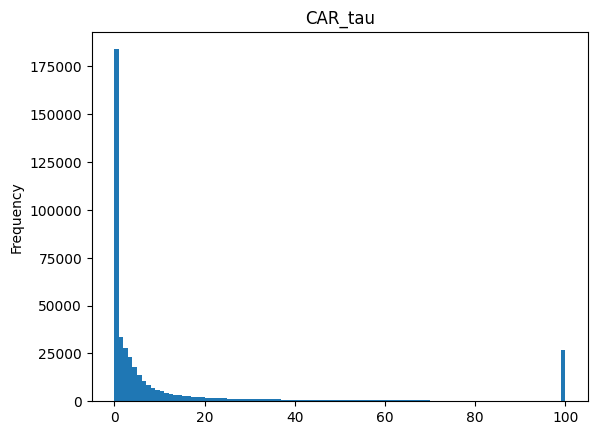

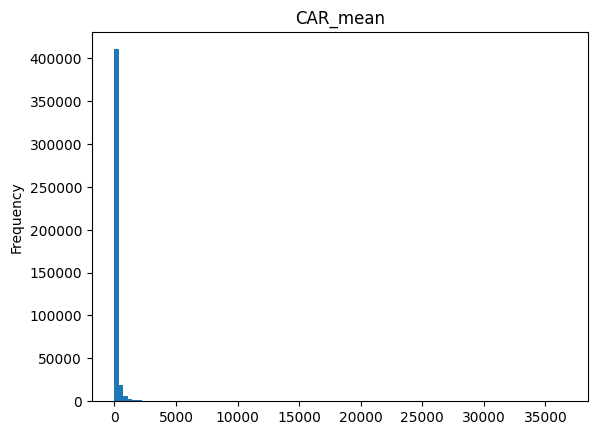

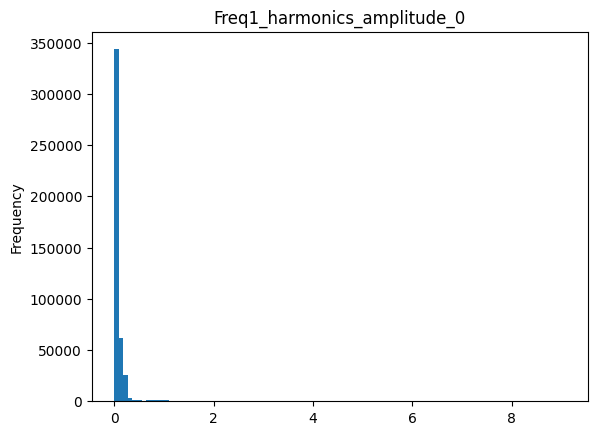

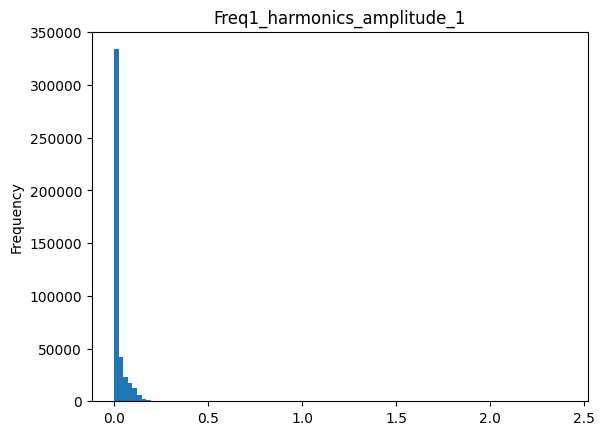

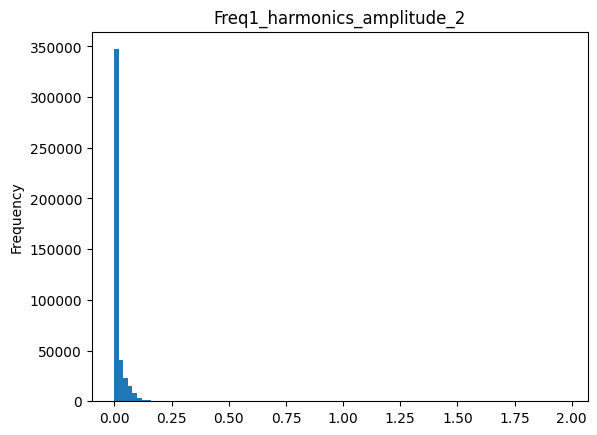

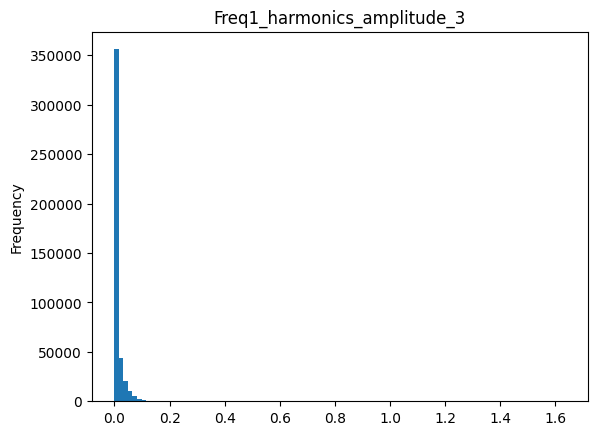

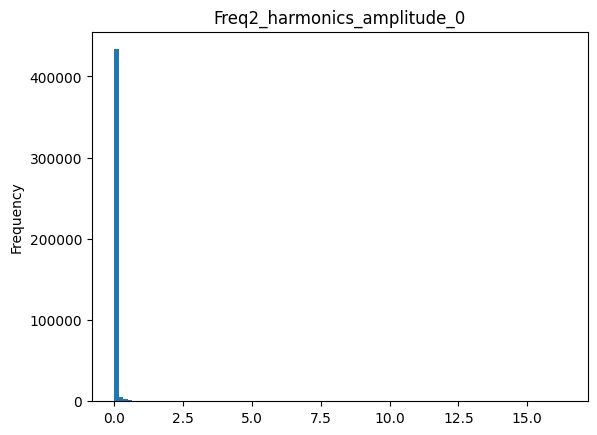

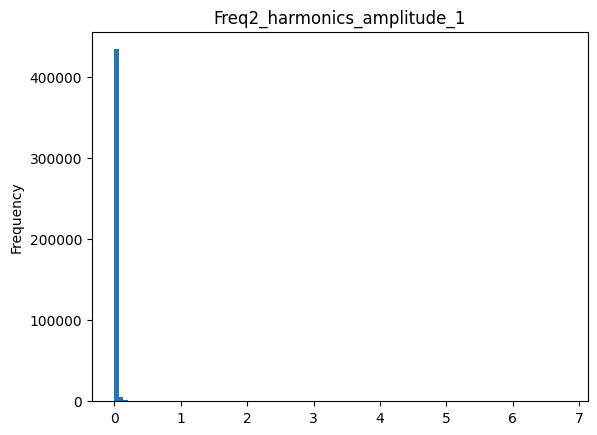

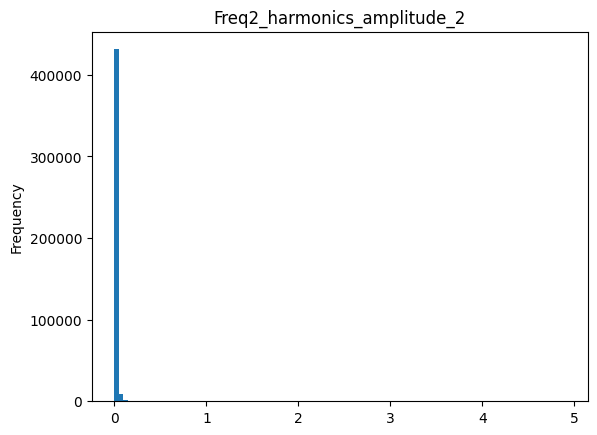

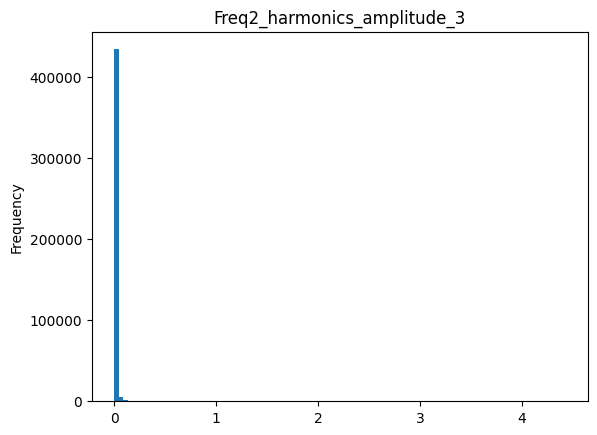

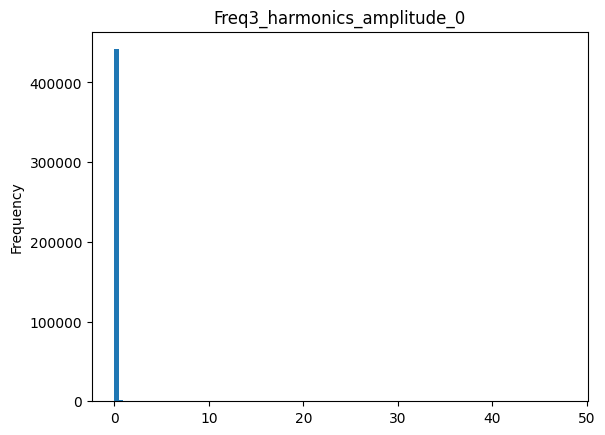

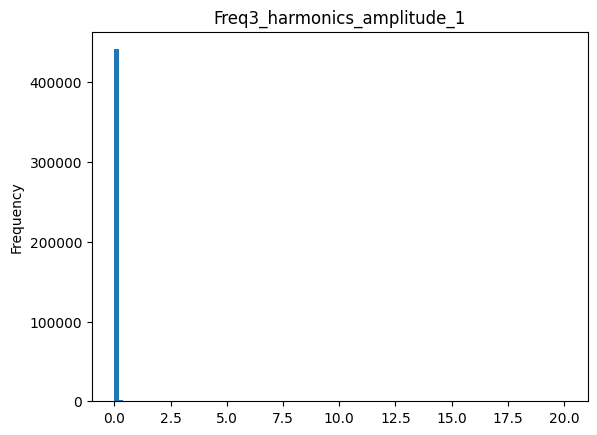

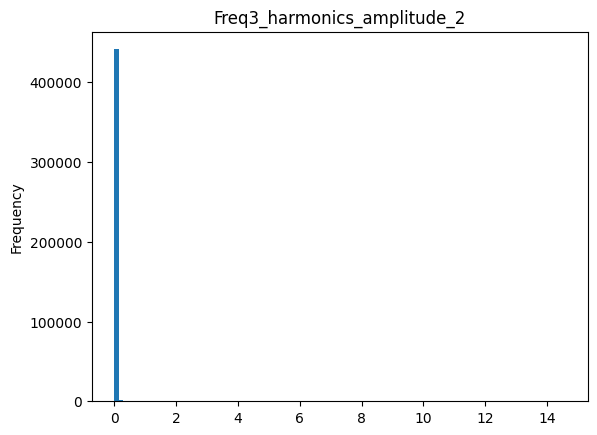

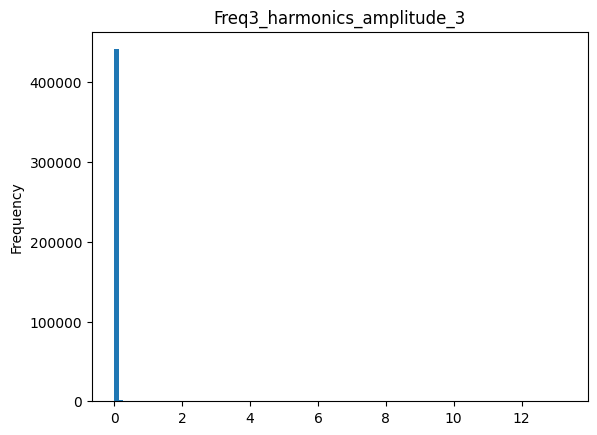

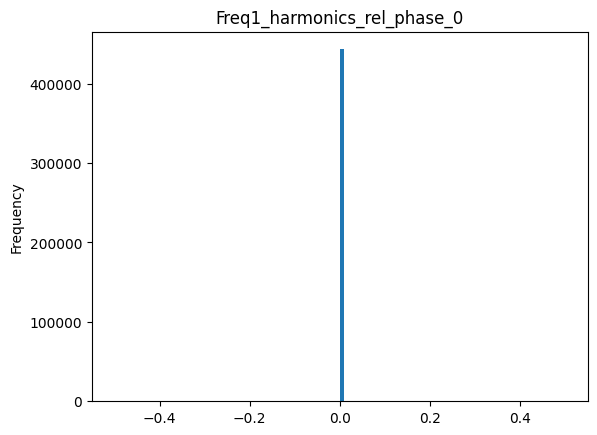

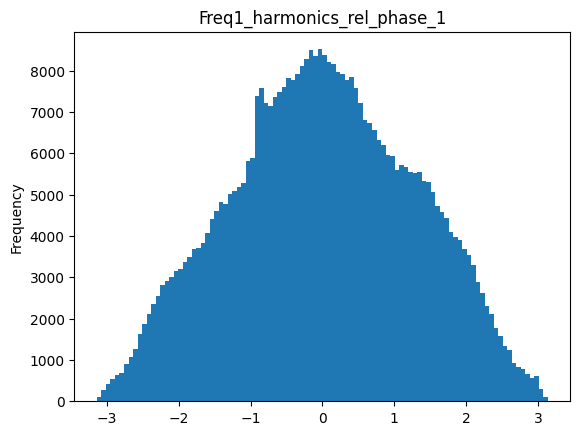

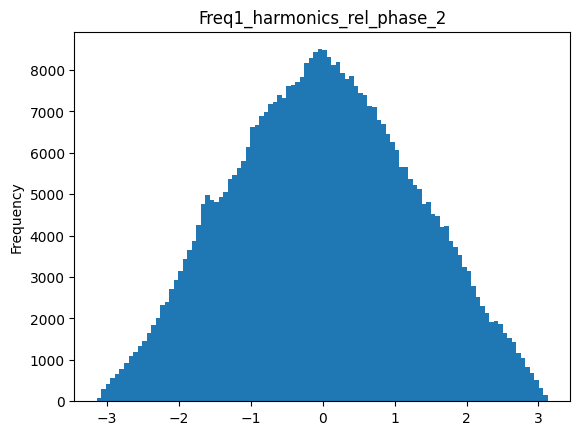

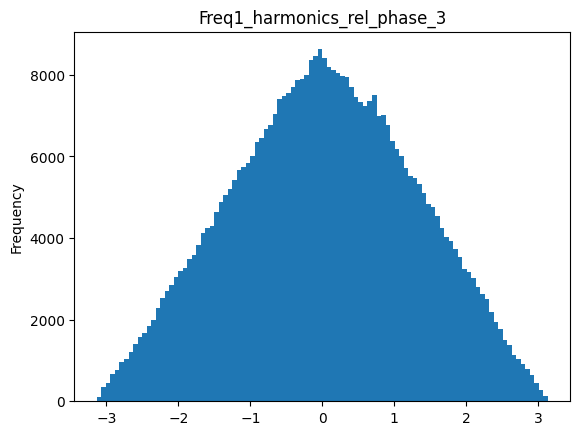

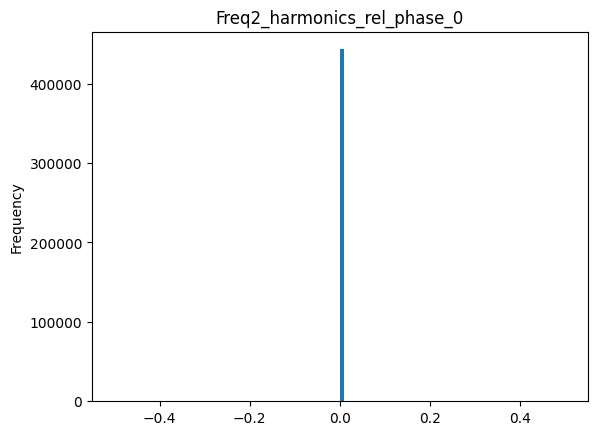

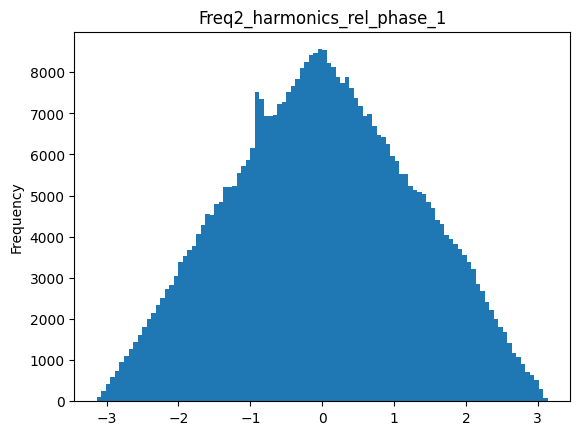

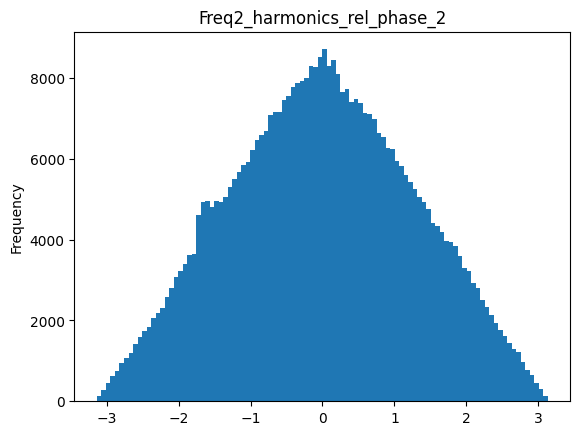

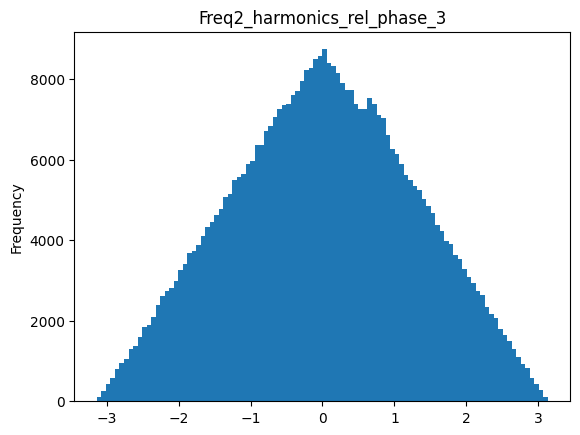

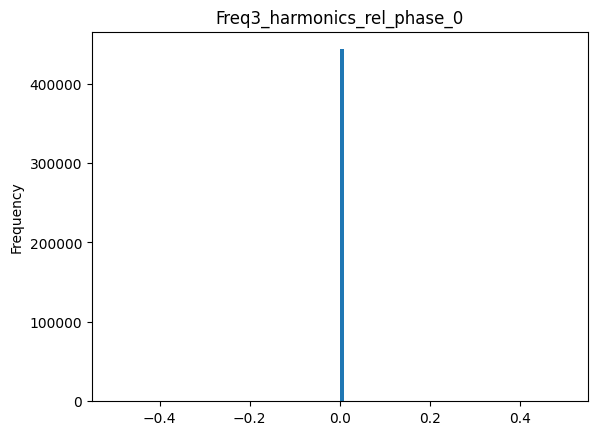

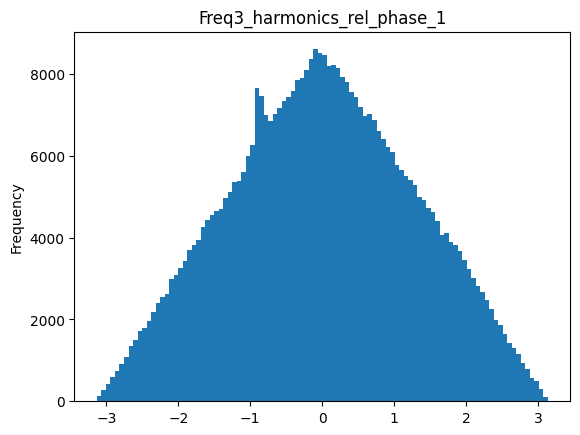

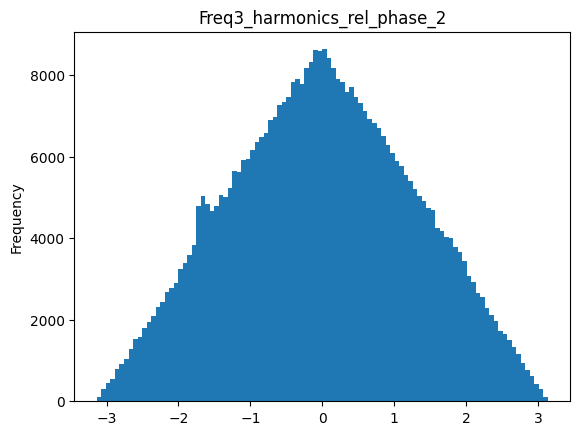

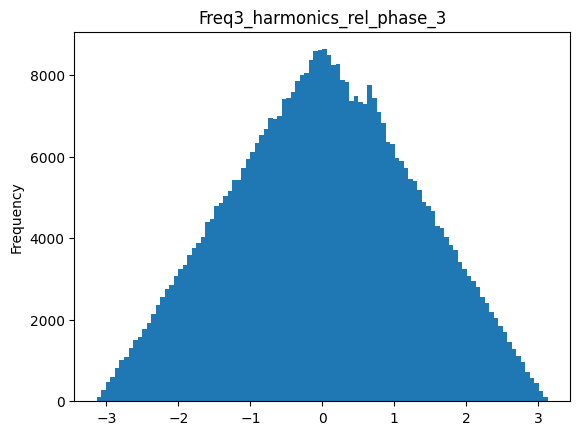

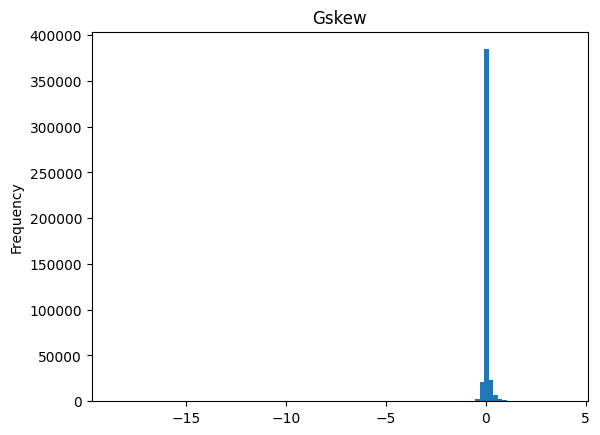

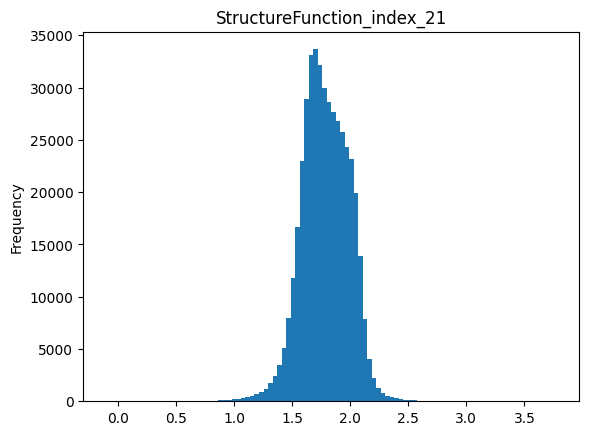

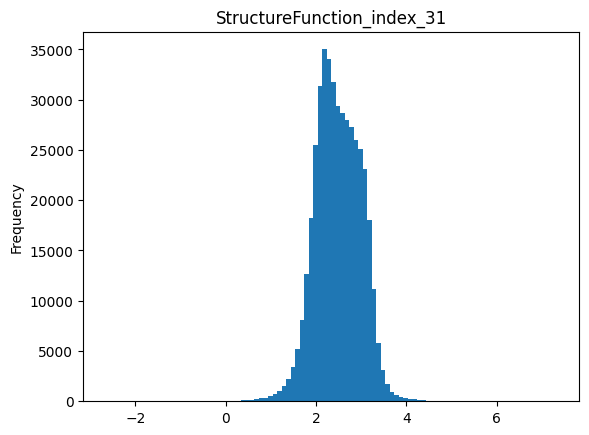

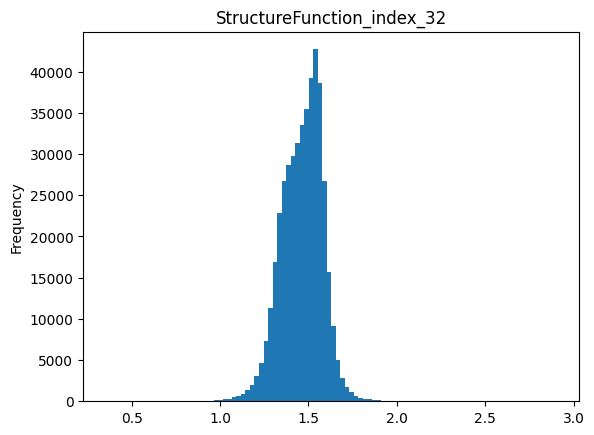

In [5]:
for col in data.columns:
    if col == 'label':
        continue
    data[col].plot.hist(subplots=True, legend=False, bins=100)
    plt.title(col)
    plt.show()

As we could see from hists above:
1. Few features contain outliers
2. Majority of distributions are skewed
3. Some of columns seem to contain only zeroes

In [6]:
allsame = []
for col in data.columns:
    if col == 'label':
        continue
    minimum, maximum = data[col].min(), data[col].max()
    if m.isclose(minimum, maximum):
        print(f'{col}. min: {minimum}, max: {maximum}')
        allsame.append(col)

Freq1_harmonics_rel_phase_0. min: 0.0, max: 0.0
Freq2_harmonics_rel_phase_0. min: 0.0, max: 0.0
Freq3_harmonics_rel_phase_0. min: 0.0, max: 0.0


As we could see, there are only 3 features where minimum and maximum are the same. So, we may safely drop those three.

In [7]:
data['label'].value_counts()

label
lpv      343805
rrlyr     44262
ecl       43534
cep        8026
dsct       2859
t2cep       603
dpv         137
acep         83
dn           40
rcb          23
acv           5
yso           3
wd            1
Name: count, dtype: int64

## Data cleaning
To keep data slightly balanced we:
1. Drop classes for which we have less than 200 records
2. Sample at most 4k light curves from other classes.

In [8]:
counts = data['label'].value_counts()
classes = counts.index.to_list()
small_classes = counts[counts < 200].index.to_list()
small_classes

['dpv', 'acep', 'dn', 'rcb', 'acv', 'yso', 'wd']

In [9]:
clean_data = data.drop(columns=allsame)
clean_data = clean_data[~clean_data.label.isin(small_classes)]

## Sample data

In [10]:
np.random.seed(42)
MAX_LCS = 4000
samples = []
for cl in clean_data.label.unique():
    cl_data = clean_data[clean_data.label == cl]
    if cl_data.shape[0] <= MAX_LCS:
        samples.append(cl_data)
    else:
        sample = cl_data.sample(n=MAX_LCS)
        samples.append(sample)

In [11]:
sampled_data = pd.concat(samples)
sampled_data.head()

,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,SlottedA_length,StetsonK_AC,Con,Beyond1Std,SmallKurtosis,...,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,Gskew,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
324752,0.0160,0.227323,0.773246,0.000588,3,3.42628,0.657717,0.002008,0.318000,0.676291,...,1.164186,2.687652,-0.378376,-0.454994,-0.239137,-0.002,1.542333,1.983232,1.322695,lpv
402074,0.1660,0.158130,0.799703,0.006557,12,0.09134,0.604699,0.004926,0.352941,-0.492961,...,0.809100,2.487433,1.437925,2.692141,2.548255,0.012,2.000400,3.032900,1.532293,lpv
394696,0.0545,0.156885,0.761709,0.001724,5,0.21093,0.814364,0.024096,0.254000,1.244295,...,0.988544,-1.010517,0.147808,-0.816050,-0.739015,0.030,1.805189,2.583875,1.537683,lpv
429312,0.0265,0.222856,0.794185,0.000928,21,0.36450,0.780998,0.002008,0.334000,-0.301263,...,1.508004,0.898144,0.016726,0.504889,-0.650614,0.000,1.875600,2.658952,1.441822,lpv
395816,0.9785,0.306884,0.856130,0.050060,24,0.35616,0.795528,0.010040,0.458000,-1.135386,...,0.923218,0.439038,0.042831,0.473247,-0.282424,0.510,1.942122,2.858433,1.487987,lpv


In [12]:
y = sampled_data.label.reset_index(drop=True)
X = sampled_data.drop(columns=['label']).reset_index(drop=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

## Setting baseline

In [14]:
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for train_idx, test_idx in tqdm.tqdm(kfold.split(X_train, y_train)):
    model = sklearn.ensemble.RandomForestClassifier(min_samples_leaf=50,n_jobs=-1)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_pred = model.predict(X_train.iloc[test_idx])
    print(metrics.classification_report(y_train.iloc[test_idx], y_pred))

1it [00:00,  2.63it/s]

              precision    recall  f1-score   support

         cep       0.90      0.94      0.92       320
        dsct       0.96      0.98      0.97       228
         ecl       0.97      0.93      0.95       320
         lpv       0.94      0.99      0.96       320
       rrlyr       0.93      0.97      0.95       320
       t2cep       0.94      0.31      0.46        49

    accuracy                           0.94      1557
   macro avg       0.94      0.85      0.87      1557
weighted avg       0.94      0.94      0.94      1557



2it [00:00,  2.68it/s]

              precision    recall  f1-score   support

         cep       0.92      0.95      0.93       320
        dsct       0.95      0.95      0.95       228
         ecl       0.96      0.93      0.95       320
         lpv       0.95      0.99      0.97       320
       rrlyr       0.92      0.97      0.94       320
       t2cep       1.00      0.39      0.56        49

    accuracy                           0.94      1557
   macro avg       0.95      0.86      0.88      1557
weighted avg       0.94      0.94      0.94      1557



3it [00:01,  2.69it/s]

              precision    recall  f1-score   support

         cep       0.91      0.94      0.93       320
        dsct       0.93      0.94      0.93       229
         ecl       0.97      0.94      0.96       320
         lpv       0.93      0.99      0.96       320
       rrlyr       0.93      0.95      0.94       320
       t2cep       0.89      0.33      0.48        48

    accuracy                           0.93      1557
   macro avg       0.93      0.85      0.87      1557
weighted avg       0.93      0.93      0.93      1557



4it [00:01,  2.67it/s]

              precision    recall  f1-score   support

         cep       0.90      0.95      0.92       320
        dsct       0.94      0.95      0.94       229
         ecl       0.97      0.95      0.96       320
         lpv       0.96      1.00      0.98       320
       rrlyr       0.96      0.97      0.96       320
       t2cep       0.81      0.27      0.41        48

    accuracy                           0.94      1557
   macro avg       0.92      0.85      0.86      1557
weighted avg       0.94      0.94      0.94      1557



5it [00:01,  2.68it/s]

              precision    recall  f1-score   support

         cep       0.90      0.94      0.92       320
        dsct       0.95      0.92      0.93       229
         ecl       0.95      0.95      0.95       320
         lpv       0.95      1.00      0.97       320
       rrlyr       0.93      0.94      0.93       320
       t2cep       0.76      0.27      0.40        48

    accuracy                           0.93      1557
   macro avg       0.90      0.84      0.85      1557
weighted avg       0.93      0.93      0.92      1557



6it [00:02,  2.69it/s]

              precision    recall  f1-score   support

         cep       0.89      0.94      0.92       320
        dsct       0.96      0.93      0.95       229
         ecl       0.96      0.97      0.96       320
         lpv       0.95      0.99      0.97       320
       rrlyr       0.95      0.96      0.96       320
       t2cep       0.85      0.23      0.36        48

    accuracy                           0.94      1557
   macro avg       0.93      0.84      0.85      1557
weighted avg       0.94      0.94      0.93      1557



7it [00:02,  2.70it/s]

              precision    recall  f1-score   support

         cep       0.91      0.95      0.93       320
        dsct       0.94      0.95      0.95       229
         ecl       0.95      0.94      0.95       320
         lpv       0.95      0.99      0.97       320
       rrlyr       0.95      0.96      0.96       320
       t2cep       0.94      0.31      0.47        48

    accuracy                           0.94      1557
   macro avg       0.94      0.85      0.87      1557
weighted avg       0.94      0.94      0.93      1557



8it [00:02,  2.71it/s]

              precision    recall  f1-score   support

         cep       0.92      0.95      0.94       320
        dsct       0.94      0.96      0.95       229
         ecl       0.98      0.92      0.95       320
         lpv       0.94      0.99      0.97       320
       rrlyr       0.94      0.97      0.96       320
       t2cep       0.96      0.48      0.64        48

    accuracy                           0.94      1557
   macro avg       0.95      0.88      0.90      1557
weighted avg       0.95      0.94      0.94      1557



9it [00:03,  2.72it/s]

              precision    recall  f1-score   support

         cep       0.94      0.95      0.94       320
        dsct       0.96      0.93      0.95       229
         ecl       0.94      0.95      0.95       320
         lpv       0.95      0.99      0.97       320
       rrlyr       0.93      0.95      0.94       320
       t2cep       1.00      0.50      0.67        48

    accuracy                           0.94      1557
   macro avg       0.95      0.88      0.90      1557
weighted avg       0.94      0.94      0.94      1557



10it [00:03,  2.70it/s]

              precision    recall  f1-score   support

         cep       0.91      0.93      0.92       320
        dsct       0.96      0.91      0.93       228
         ecl       0.96      0.94      0.95       320
         lpv       0.93      0.99      0.96       320
       rrlyr       0.92      0.99      0.95       320
       t2cep       1.00      0.23      0.37        48

    accuracy                           0.93      1556
   macro avg       0.95      0.83      0.85      1556
weighted avg       0.93      0.93      0.93      1556



Lets fine-tune the model to maximize it's performance:

In [15]:
param_grid = {
    'n_estimators': [30, 50, 100, 150],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 3, 5, 7, 10, 20, 30],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],
}

In [16]:
grid = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=42),
                    param_grid,
                    scoring='f1_macro',
                    cv=10,
                    n_jobs=-1,
                    verbose=3)

In [17]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 672 candidates, totalling 6720 fits
[CV 9/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=10, n_estimators=50;, score=0.406 total time=   0.5s
[CV 3/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=50, n_estimators=30;, score=0.399 total time=   0.4s
[CV 7/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=50, n_estimators=30;, score=0.433 total time=   0.3s
[CV 5/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=50, n_estimators=50;, score=0.402 total time=   0.5s
[CV 9/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=50, n_estimators=100;, score=0.410 total time=   1.0s
[CV 3/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=100, n_estimators=100;, score=0.395 total time=   1.0s
[CV 9/10] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=200, n_estimators=30;, score=0.428 total time=   0.3s
[CV 10/

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 3, 5, 7, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'n_estimators': [30, 50, 100, 150]},
             scoring='f1_macro', verbose=3)

In [20]:
joblib.dump(grid.best_estimator_, '../models/tuned_rf.joblib')

['../models/tuned_rf.joblib']

## Evaluate best model

In [21]:
best_rf = joblib.load('../models/tuned_rf.joblib')

In [25]:
y_pred = best_rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         cep       0.95      0.97      0.96       800
        dsct       0.98      0.97      0.97       572
         ecl       0.97      0.96      0.96       800
         lpv       0.96      1.00      0.98       800
       rrlyr       0.97      0.97      0.97       800
       t2cep       0.84      0.59      0.69       121

    accuracy                           0.96      3893
   macro avg       0.94      0.91      0.92      3893
weighted avg       0.96      0.96      0.96      3893



Text(0.5, 1.0, 'Tuned random forest confusion matrix')

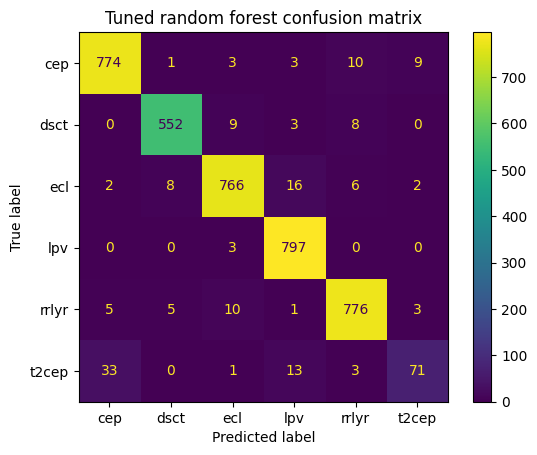

In [29]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=best_rf.classes_)
disp.plot()
plt.title('Tuned random forest confusion matrix')